# Newsvendor Intro Example

In [1]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters, plot_contours, plot_contours_line
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":24,
    "font.family": "serif"
})

In [2]:
# Formulate constants
n = 2
N = 500
test_perc = 0.99
# k = npr.uniform(1,4,n)
# p = k + npr.uniform(2,5,n)
k_init = np.array([4.,5.])
p = np.array([5,6.5])
# k_tch = torch.tensor(k, requires_grad = True)?
# p_tch = torch.tensor(p, requires_grad = True)

def gen_demand_intro(N, seed):
    np.random.seed(seed)
    sig = np.array([[0.6,-0.3],[-0.3,0.1]])
    mu = np.array((1.1,1.7))
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

def gen_demand_cor(N,seed,x):
    np.random.seed(seed)
    sig = np.eye(2)
    mu = np.array((6,7))
    points_list = []
    for i in range(N):
        mu_shift = -0.4*x[i]
        newpoint = np.random.multivariate_normal(mu+mu_shift,sig)
        points_list.append(newpoint)
    return np.vstack(points_list)
        
# Generate data
# data = gen_demand_intro(N, seed=5)
rawdata = gen_demand_intro(N, seed=18)

In [3]:
num_scenarios = N
num_reps = int(N/num_scenarios)
k_data = np.maximum(0.5,k_init + np.random.normal(0,3,(num_scenarios,n)))
p_data = k_data + np.maximum(0,np.random.normal(0,3,(num_scenarios,n)))
p_data = np.vstack([p_data]*num_reps)
k_data = np.vstack([k_data]*num_reps)

data = gen_demand_cor(N,seed=5,x=p_data)

In [4]:
def gen_weights_bias(k_data,p_data, data):
    stacked_context = np.hstack([p_data,k_data,np.ones((N,1))])
    mults_1 = np.linalg.lstsq(stacked_context,data[:,0])[0]
    mults_2 = np.linalg.lstsq(stacked_context,data[:,1])[0]
    mults_mean = np.vstack([mults_1, mults_2])
    mults_mean_weight = mults_mean[:,:-1]
    mults_mean_bias = mults_mean[:,-1]
    return mults_mean_weight, mults_mean_bias
mults_mean_weight, mults_mean_bias = gen_weights_bias(k_data,p_data, data)

In [14]:
mults_mean_bias, mults_mean_weight

(array([5.93693493, 7.09945197]),
 array([[-0.38260275, -0.01373402,  0.00918962,  0.00764167],
        [-0.01988204, -0.39864121,  0.02866319, -0.01608723]]))

In [5]:
# Formulate uncertainty set
u = lropt.UncertainParameter(n,
                        uncertainty_set=lropt.Ellipsoidal(
                                                    data=data))
# Formulate the Robust Problem
x_r = cp.Variable(n)
t = cp.Variable()
k = lropt.ContextParameter(2, data=k_data)
p = lropt.ContextParameter(2, data=p_data)
p_x = cp.Variable(n)
objective = cp.Minimize(t)
constraints = [lropt.max_of_uncertain([-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p_x[1]*u[1], -p_x[0]*u[0] - p[1]*x_r[1], -p_x[0]*u[0]- p_x[1]*u[1]]) + k@x_r <= t]
constraints += [p_x == p]
constraints += [x_r >= 0]

eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)
target = -0.0
test_p = 0.9
s = 8
np.random.seed(s)
# setup intial A, b
test_indices = np.random.choice(N,int(0.9*N), replace=False)
train_indices = [i for i in range(N) if i not in test_indices]
train = np.array([data[i] for i in train_indices])
test = np.array([data[i] for i in test_indices])

init = sc.linalg.sqrtm(np.cov(train.T))
init_bval = np.mean(train, axis=0)

np.random.seed(15)
#initn = 5*np.random.rand(n,2)
# initn = np.eye(n) + 5*np.random.rand(n,2)
# init_bvaln = np.mean(train, axis=0)
initn = sc.linalg.sqrtm(np.cov(train.T))
init_bvaln = np.mean(train, axis=0)
# init_bias = np.hstack([initn.flatten(),np.array([6,7])])
# init_weight = np.vstack([np.zeros((4,4)),np.array([[-0.4,0,0,0],[0,-0.4,0,0]])])
init_bias = np.hstack([initn.flatten(),mults_mean_bias])
init_weight = np.vstack([np.zeros((4,4)),mults_mean_weight])

# Train A and b
from lropt import Trainer
trainer = Trainer(prob)
trainer_settings = lropt.TrainerSettings()
trainer_settings.lr=0.0001
trainer_settings.train_size = False
trainer_settings.num_iter=300
trainer_settings.optimizer="SGD"
trainer_settings.seed=5
trainer_settings.init_A=initn
trainer_settings.init_b=init_bvaln
trainer_settings.init_lam=0.5
trainer_settings.init_mu=0.5
trainer_settings.mu_multiplier=1.001
trainer_settings.test_percentage = test_p
trainer_settings.save_history = True
trainer_settings.quantiles = (0.4,0.6)
trainer_settings.lr_step_size = 50
trainer_settings.lr_gamma = 0.5
trainer_settings.random_init = False
trainer_settings.num_random_init = 3
trainer_settings.parallel = True
trainer_settings.position = False
trainer_settings.eta=0.3
trainer_settings.contextual = True
trainer_settings.init_weight = init_weight
trainer_settings.init_bias = init_bias
result = trainer.train(trainer_settings=trainer_settings)
df = result.df
A_fin = result.A
b_fin = result.b

/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: Us

iteration 0, valid -4.5812e+00, vio 3.7081e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 10, valid -1.0581e+00, vio 1.5004e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 20, valid -2.6317e+00, vio 4.5599e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 30, valid -2.8321e+00, vio 3.2463e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 40, valid -3.3372e+00, vio 8.7970e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 50, valid -4.1183e+00, vio 3.5685e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 60, valid -3.1651e+00, vio 1.0578e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 70, valid -3.7058e+00, vio 1.3863e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 80, valid -5.0796e+00, vio 1.5004e-02


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 90, valid -7.3071e+00, vio 2.4908e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 100, valid -5.2404e+00, vio 1.0656e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 110, valid -4.7479e+00, vio 1.3354e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 120, valid -5.9872e+00, vio 3.1877e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 130, valid -6.3086e+00, vio 1.8340e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 140, valid -7.0328e+00, vio 1.0212e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 150, valid -7.9383e+00, vio 7.9396e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 160, valid -4.8725e+00, vio 4.3610e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 170, valid -4.3456e+00, vio 6.5336e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 180, valid -5.5234e+00, vio 8.3992e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 190, valid -3.3904e+00, vio 1.1686e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 200, valid -4.1704e+00, vio 7.8827e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 210, valid -2.3682e+00, vio 3.6103e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 220, valid -3.6391e+00, vio 1.8150e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 230, valid -4.6220e+00, vio 1.1156e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 240, valid -5.2979e+00, vio 1.5902e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 250, valid -5.5338e+00, vio 6.6679e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 260, valid -3.4807e+00, vio 2.1419e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 270, valid -5.5408e+00, vio 1.4849e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 280, valid -3.7566e+00, vio 3.1344e+00


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

iteration 290, valid -4.9841e+00, vio 5.9332e-01


/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_0 = [torch.tensor(x, dtype=settings.DTYPE) for x in x_0]
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/Desktop/Princeton/Project2/lropt/lropt/train/trainer.py:158: UserWarning: To copy constru

In [6]:
# Grid search epsilon
eps_list = np.linspace(0.5, 2.5, 10)
result4 = trainer.grid(rholst=eps_list, init_A=init,
                    init_b=init_bval, seed=8,
                    init_alpha=0., test_percentage=test_p, quantiles = (0.3, 0.7))
dfgrid = result4.df

result5 = trainer.grid(rholst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.3,0.7), contextual = True, linear = result._linear)
dfgrid2 = result5.df

In [7]:
epslst =eps_list
prob_list = np.array([0.,0.01,0.05,0.1])
inds_standard = []
inds_reshaped = []
for i in prob_list:
    inds_standard.append(np.absolute(np.mean(np.vstack(dfgrid['Avg_prob_test']),axis = 1)-i).argmin())
    inds_reshaped.append(np.absolute(np.mean(np.vstack(dfgrid2['Avg_prob_test']),axis = 1)-i).argmin())

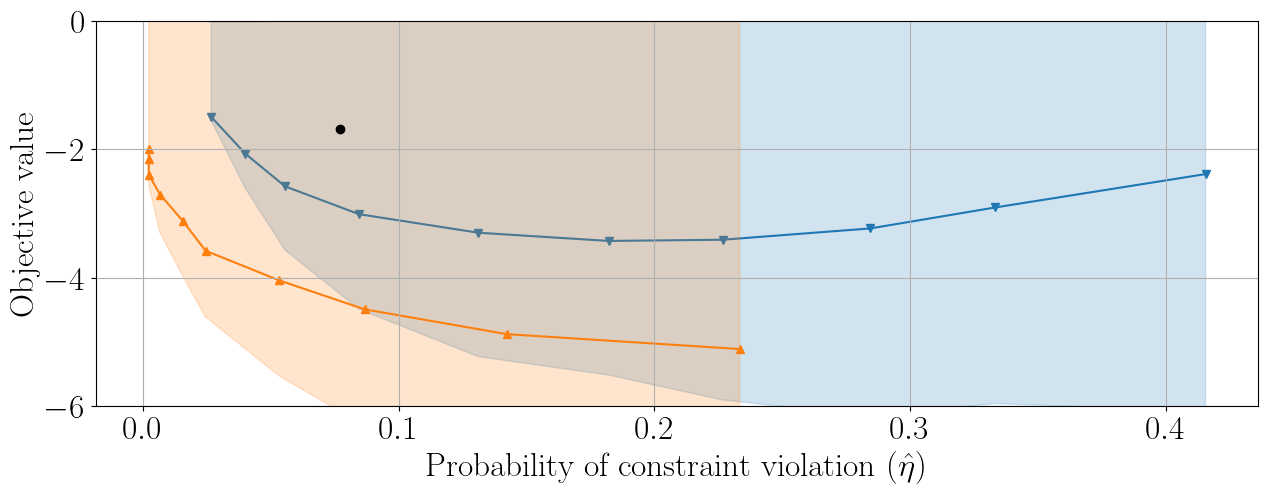

In [12]:
# indss = [5,9,13,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]
# dfgrid, dfgrid2 = results_grid4[(16,0.3)]
beg1, end1 = 0, 100
beg2, end2 = 0, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(dfgrid['Avg_prob_test'][beg1:end1],dfgrid['Avg_prob_test'][beg1:end1][::-1]), np.append(dfgrid['Lower_test'][beg1:end1],dfgrid['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)
# for ind in range(4):
#     plt.scatter(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
#         dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped set", marker="^", zorder=1)
plt.fill(np.append(dfgrid2['Avg_prob_test'][beg2:end2],dfgrid2['Avg_prob_test'][beg2:end2][::-1]), np.append(dfgrid2['Lower_test'][beg2:end2],dfgrid2['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)
# for ind in [0, 2, 1, 3]:
#     plt.scatter(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[inds_reshaped[ind]], np.mean(
#         np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.xscale("log")
plt.ylim([-6, 0])
plt.grid()
# minv, maxv = (-0.25,-0.1)
# minv, maxv = (-0.28,-0.17)
# plt.vlines(ymin=minv, ymax=maxv, x=prob_list[0], linestyles=":",
#            color="tab:red", label="Reference $\hat{\eta}$")
# for i in prob_list[1:]:
#     plt.vlines(ymin=minv, ymax=maxv, x=i, linestyles=":", color="tab:red")
# plt.legend(loc="upper right")
# plt.ylim([-0.275,-0.175])
plt.scatter(0.077,-1.68, color = "black")
plt.savefig("news_objective_vs_violations.pdf", bbox_inches='tight')

In [9]:
K = 5
Amat = result._a_history[-1]*result.rho
bvec = result._b_history[-1]
eps_fin = result.rho
num_p = 50
offset = 5
x_min, x_max = np.min(train[:,0]) - offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
X = np.linspace(x_min,x_max,num_p)
Y = np.linspace(y_min,y_max,num_p)
x,y = np.meshgrid(X,Y)
# Z values as a matrix
fin_set = {}
init_set = {}
for ind in range(4):
    fin_set[ind] = {}
    init_set[ind] = {}
    for k_ind in range(K):
        fin_set[ind][k_ind] = np.zeros((num_p,num_p))
        init_set[ind][k_ind] = np.zeros((num_p,num_p))
g_level_learned = {}
g_level_base = {}
for ind in range(4):
    g_level_learned[ind] = {}
    g_level_base[ind] = {}
    for scene in range(10):
        g_level_learned[ind][scene] = np.zeros((num_p,num_p))
        g_level_base[ind][scene] = np.zeros((num_p,num_p))
    for i in range(num_p):
        for j in range(num_p):
            u_vec = [x[i,j], y[i,j]]
            for k_ind in range(K):
                fin_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_reshaped[ind]])*(Amat[k_ind].T@np.linalg.inv(Amat[k_ind]@Amat[k_ind].T))@(u_vec - bvec[k_ind]))

            for k_ind in range(K):
                init_set[ind][k_ind][i,j] = np.linalg.norm((1/eps_list[inds_standard[ind]])*(init.T@np.linalg.inv(init@init.T))@(u_vec  - init_bval))

In [10]:
def plot_contours_line(x,y,set, g_level,prob_list, num_scenarios,train, title, standard = True, K=1):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 3.5), constrained_layout= True)
    ax_lst = [ax1, ax2, ax3, ax4]
    np.random.seed(0)
    newtrain = np.random.choice(train.shape[0],size=train.shape[0],replace=False)
    cur_ind = 0
    for axis in ax_lst:
        axis.set_title(r'$\hat{\eta}$' + ' = {}'.format(prob_list[cur_ind]))
        axis.set_xlabel(r"$u_1$")
        axis.set_ylabel(r"$u_2$")
        # for scene in range(num_scenarios):
        #     axis.contour(x,y,g_level[cur_ind][scene],[0], colors = ["tab:purple"],alpha = 1,linestyles = ["-"])
        axis.scatter(train[:,0][newtrain],train[:,1][newtrain], color = "white",edgecolor = "black")
        axis.scatter(np.mean(train,axis= 0)[0], np.mean(train,axis= 0)[1],color = ["tab:green"])
        for k_ind in range(K):
            axis.contour(x,y,set[cur_ind][k_ind], [1], colors = ["red"],linewidths = [2])
        cur_ind +=1
    if standard:
        post = "Mean-Variance"
    else:
        post = "Reshaped"
    fig.suptitle(post+" set", fontsize = 30)
    plt.savefig(title+"_"+ post + ".pdf", bbox_inches='tight')

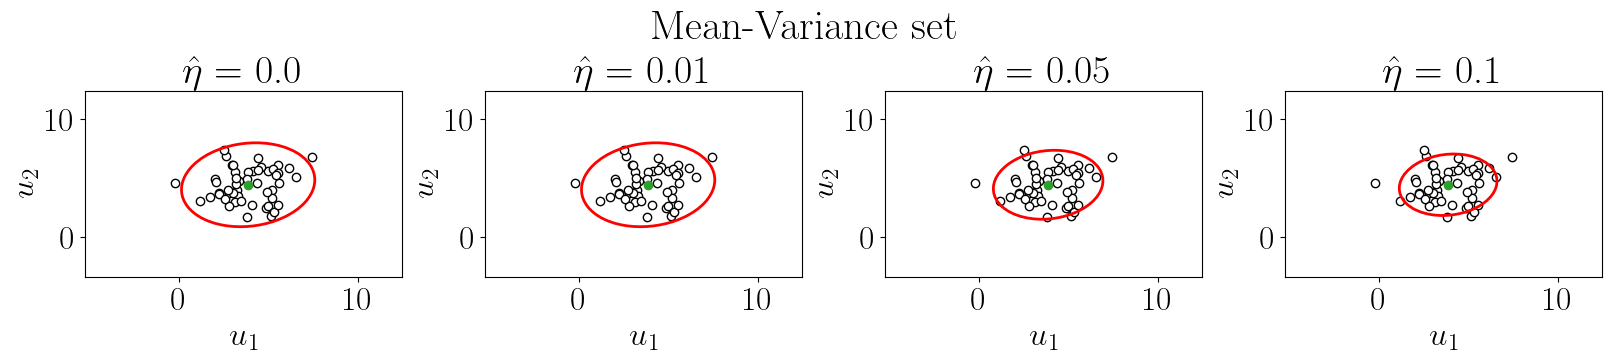

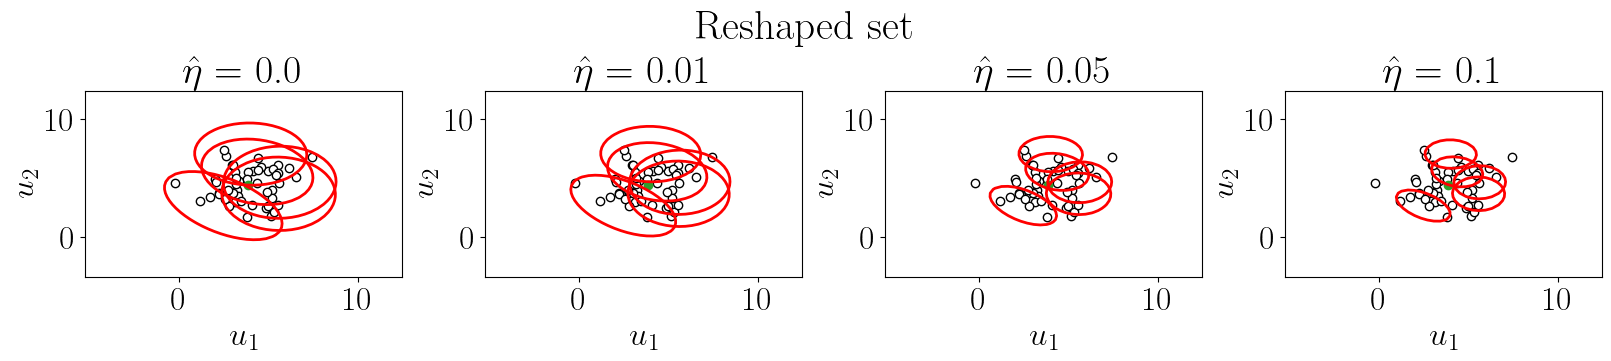

In [11]:
plot_contours_line(x,y,init_set, g_level_base,prob_list,num_scenarios,train, "news_intro4",standard = True) 
plot_contours_line(x,y,fin_set, g_level_learned,prob_list,num_scenarios,train, "news_intro4",standard = False, K=5)

In [45]:
results_fin = {}
results_df = {}
results_grid = {}
seed = 13
N = 500
for reps in range(20):
  print(reps)
  # k = np.array([4.,5.])
  # num_scenarios = 10
  # num_reps = int(N/10)
  # k_data = k + np.random.normal(0,1,(num_scenarios,n))
  # p_data = k_data + np.maximum(0,np.random.normal(0,1,(num_scenarios,n)))
  # p_data = np.vstack([p_data]*num_reps)
  # k_data = np.vstack([k_data]*num_reps)
  #indss = [5,9,13,18,19,20,21,22,23,25,26,27,28,29,30,31,32,33,34,35]
  indss = np.arange(5,25)
  np.random.seed(indss[reps])
  # data = gen_demand_intro(N, seed=list[reps])
  k_data = np.maximum(0.5,k_init + np.random.normal(0,3,(num_scenarios,n)))
  p_data = k_data + np.maximum(0,np.random.normal(0,3,(num_scenarios,n)))
  data = gen_demand_cor(N, seed=indss[reps],x=p_data)
  mults_mean_weight, mults_mean_bias = gen_weights_bias(k_data,p_data, data)
  for etas in [0.3]:
# Formulate uncertainty set
    u = lropt.UncertainParameter(n,
                            uncertainty_set=lropt.Ellipsoidal(
                                                        data=data))
    # Formulate the Robust Problem
    x_r = cp.Variable(n)
    t = cp.Variable()
    k = lropt.ContextParameter(2, data=k_data)
    p = lropt.ContextParameter(2, data=p_data)
    p_x = cp.Variable(n)
    objective = cp.Minimize(t)
    constraints = [lropt.max_of_uncertain([-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p_x[1]*u[1], -p_x[0]*u[0] - p[1]*x_r[1], -p_x[0]*u[0]- p_x[1]*u[1]]) + k@x_r <= t]
    constraints += [p_x == p]
    constraints += [x_r >= 0]

    eval_exp = k@x_r + cp.maximum(-p[0]*x_r[0] - p[1]*x_r[1],-p[0]*x_r[0] - p[1]*u[1], -p[0]*u[0] - p[1]*x_r[1], -p[0]*u[0]- p[1]*u[1]) 

    prob = lropt.RobustProblem(objective, constraints,eval_exp = eval_exp)
    target = -0.0
    test_p = 0.90
    s = 8

    # setup intial A, b
    train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=s)
    init = sc.linalg.sqrtm(np.cov(train.T))
    init_bval = np.mean(train, axis=0)

    np.random.seed(15)
    #initn = 5*np.random.rand(n,2)
    # initn = np.eye(n) + 5*np.random.rand(n,2)
    # init_bvaln = np.mean(train, axis=0)
    initn = sc.linalg.sqrtm(np.cov(train.T))
    init_bvaln = np.mean(train, axis=0)
    init_bias = np.hstack([initn.flatten(),mults_mean_bias])
    init_weight = np.vstack([np.zeros((4,4)),mults_mean_weight])
    # Train A and b
    trainer = lropt.Trainer(prob)
    result = trainer.train(lr=0.0001, num_iter=500, optimizer="SGD",seed=5, init_A=initn, init_b=init_bvaln, init_lam=1, init_mu=1,
                        mu_multiplier=1.01, kappa=0., init_alpha=0., test_percentage = test_p,save_history = True, quantiles = (0.4,0.6), lr_step_size = 10, lr_gamma = 0.9, random_init = False, num_random_init = 20, parallel = True, position = False, eta=0.3, contextual = True, init_weight = init_weight, init_bias = init_bias)
    df = result.df
    A_fin = result.A
    b_fin = result.b
    results_fin[(reps,etas)] = (A_fin,b_fin)
    results_df[(reps,etas)] = df
    # Grid search epsilon
    eps_list = np.linspace(0.5, 5.5, 80)
    result4 = trainer.grid(rholst=eps_list, init_A=init,
                        init_b=init_bval, seed=8,
                        init_alpha=0., test_percentage=test_p, quantiles = (0.4, 0.6))
    dfgrid = result4.df

    result5 = trainer.grid(rholst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6), contextual = True, linear = result._linear)


    dfgrid2 = result5.df
    new_linear = trainer.init_linear_model(torch.tensor(initn), torch.tensor(init_bvaln),False, 1,0,init_weight, init_bias)

    result6 = trainer.grid(rholst=eps_list,init_A=A_fin, init_b=b_fin, seed=s,init_alpha=0., test_percentage=test_p,quantiles = (0.4,0.6), contextual = True, linear = new_linear)
    dfgrid3 = result6.df

    results_grid[(reps,etas)] = (dfgrid,dfgrid2,dfgrid3)

0


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

1


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

2


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

3


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

4


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

5


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

6


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

7


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

8


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

9


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

10


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

11


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

12


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

13


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

14


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

15


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

16


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

17


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

18


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

19


/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/threadpoolctl.py:1214: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)
/Users/irina.wang/anaconda3/envs/lropt_t1/lib/python3.11/site-packages/cvxtorch/utils/torch_utils.py:20: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:620.)
  return torch.sparse.FloatTensor(i, v, torch.Size(value_coo.sha

In [46]:
dfgrid, dfgrid2,dfgrid3 = results_grid[(0,0.3)]
dfgrid = dfgrid.drop(columns=["step","Probability_violations_test","z_vals"])
dfgrid2 = dfgrid2.drop(columns=["step","Probability_violations_test","z_vals"])
dfgrid3 = dfgrid3.drop(columns=["step","Probability_violations_test","z_vals"])
stacked = dfgrid["Test_val"]
stacked2 = dfgrid2["Test_val"]
stacked3 = dfgrid3["Test_val"]
# indss = np.array([9,10,12,13,16,18,19,20,22,23])
# indss = np.array([9,13,20,22])
indss = list(np.arange(1,20))
# indss.remove(6)
# indss.remove(19)
# indss.remove(17)
# indss.remove(15)
# indss.remove(9)
#indss = [1,3,4,7]
#for reps in (indss-5):
for reps in indss:
  reps = int(reps)
  newgrid, newgrid2,newgrid3 = results_grid[(reps,0.3)]
  newgrid = newgrid.drop(columns=["step","Probability_violations_test","z_vals"])
  dfgrid = dfgrid.add(newgrid.reset_index(), fill_value=0)
  newgrid2 = newgrid2.drop(columns=["step","Probability_violations_test","z_vals"])
  dfgrid2 = dfgrid2.add(newgrid2.reset_index(), fill_value=0)
  newgrid3 = newgrid3.drop(columns=["step","Probability_violations_test","z_vals"])
  dfgrid3 = dfgrid3.add(newgrid3.reset_index(), fill_value=0)
  stacked = np.vstack([stacked,newgrid["Test_val"]])
  stacked2 = np.vstack([stacked2,newgrid2["Test_val"]])
  stacked3 = np.vstack([stacked3,newgrid3["Test_val"]])
dfgrid = dfgrid/(len(indss)+1)
dfgrid2 = dfgrid2/(len(indss)+1)
dfgrid3 = dfgrid3/(len(indss)+1)
dfgrid["Lower_test"] = np.quantile(stacked,0.4,axis=0)
dfgrid["Upper_test"] = np.quantile(stacked,0.9,axis=0)
dfgrid2["Lower_test"] = np.quantile(stacked2,0.4,axis=0)
dfgrid2["Upper_test"] = np.quantile(stacked2,0.9,axis=0)
dfgrid3["Lower_test"] = np.quantile(stacked3,0.4,axis=0)
dfgrid3["Upper_test"] = np.quantile(stacked3,0.9,axis=0)
dfgrid.to_csv("dfgrid_3")
dfgrid2.to_csv("dfgrid2_3")
dfgrid3.to_csv("dfgrid3_3")
np.save("stacked_3.npy",stacked)
np.save("stacked2_3.npy",stacked2)
np.save("stacked3_3.npy",stacked3)

In [43]:
# dfgrid, dfgrid2 = results_grid3[(0,0.3)]
# A_fin,b_fin = results_fin3[(0,0.3)]

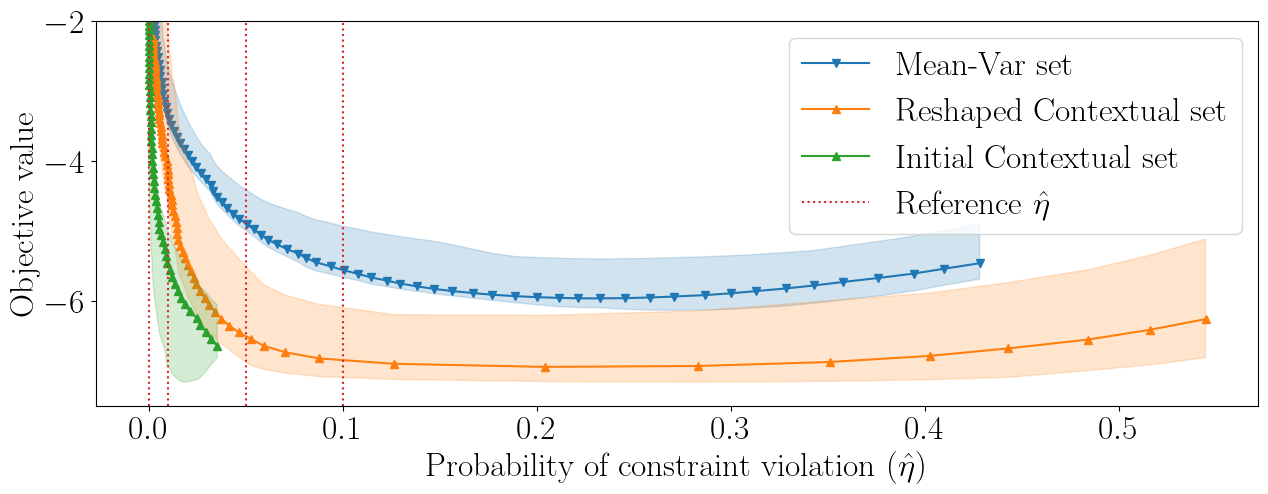

In [47]:
# cur = 23
#0,1,3,4,5
#0,1,2,3,4,
# dfgrid, dfgrid2,dfgrid3 = results_grid[(4,0.3)]
beg1, end1 = 0, 100
beg2, end2 = 0, 100
beg3, end3 = 0, 100
plt.figure(figsize=(15, 5))
plt.plot(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[beg1:end1], np.mean(np.vstack(
    dfgrid['Test_val']), axis=1)[beg1:end1], color="tab:blue", label=r"Mean-Var set", marker="v", zorder=0)
plt.fill(np.append(dfgrid['Avg_prob_test'][beg1:end1],dfgrid['Avg_prob_test'][beg1:end1][::-1]), np.append(dfgrid['Lower_test'][beg1:end1],dfgrid['Upper_test'][beg1:end1][::-1]), color="tab:blue", alpha=0.2)
# for ind in range(4):
#     plt.scatter(np.mean(np.vstack(dfgrid['Avg_prob_test']), axis=1)[inds_standard[ind]], np.mean(np.vstack(
#         dfgrid['Test_val']), axis=1)[inds_standard[ind]], color="tab:green", s=50, marker="v", zorder=10)
plt.plot(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[beg2:end2], np.mean(np.vstack(
    dfgrid2['Test_val']), axis=1)[beg2:end2], color="tab:orange", label="Reshaped Contextual set", marker="^", zorder=1)
plt.fill(np.append(dfgrid2['Avg_prob_test'][beg2:end2],dfgrid2['Avg_prob_test'][beg2:end2][::-1]), np.append(dfgrid2['Lower_test'][beg2:end2],dfgrid2['Upper_test'][beg2:end2][::-1]), color="tab:orange", alpha=0.2)

plt.plot(np.mean(np.vstack(dfgrid3['Avg_prob_test']), axis=1)[beg3:end3], np.mean(np.vstack(
    dfgrid3['Test_val']), axis=1)[beg3:end3], color="tab:green", label="Initial Contextual set", marker="^", zorder=1)
plt.fill(np.append(dfgrid3['Avg_prob_test'][beg3:end3],dfgrid3['Avg_prob_test'][beg3:end3][::-1]), np.append(dfgrid2['Lower_test'][beg3:end3],dfgrid3['Upper_test'][beg3:end3][::-1]), color="tab:green", alpha=0.2)

# for ind in [0, 2, 1, 3]:
#     plt.scatter(np.mean(np.vstack(dfgrid2['Avg_prob_test']), axis=1)[inds_reshaped[ind]], np.mean(
#         np.vstack(dfgrid2['Test_val']), axis=1)[inds_reshaped[ind]], color="black", s=50, marker="^")
plt.ylabel("Objective value")
# ax2.set_xlim([-1,20])
plt.xlabel(r"Probability of constraint violation $(\hat{\eta})$")
# plt.xscale("log")
# plt.ylim([-3, 1])
# minv, maxv = (-0.25,-0.1)
minv, maxv = (-7.5,-2)
plt.vlines(ymin=minv, ymax=maxv, x=prob_list[0], linestyles=":",
           color="tab:red", label="Reference $\hat{\eta}$")
for i in prob_list[1:]:
    plt.vlines(ymin=minv, ymax=maxv, x=i, linestyles=":", color="tab:red")
plt.legend(loc="upper right")
plt.ylim([-7.5,-2])
plt.savefig("img_news_objective_vs_violations_new6.pdf", bbox_inches='tight')

## GIF

In [17]:
re_eps = eps_list[inds_reshaped[0]]
st_eps = eps_list[inds_standard[0]]

In [24]:
A_fin = result.A 
b_fin = result.b
A1_iters, b1_iters = result.uncset_iters
eps_iters = result._rho_history
num_scenarios = 5

offset = 1
x_min, x_max = np.min(train[:,0]) - 3*offset, np.max(train[:,0]) + offset
y_min, y_max = np.min(train[:,1]) - offset, np.max(train[:,1]) + offset
n_points = 100
X = np.linspace(x_min,x_max,n_points)
Y = np.linspace(y_min,y_max,n_points)
x_mesh,y_mesh = np.meshgrid(X,Y)


def level_set(A_final, b_final, offset = 2, n = n_points, x_mesh = x_mesh, y_mesh = y_mesh, contextual = False):
    if not contextual:
        unc_level_set = np.zeros((n,n))
    else:
        unc_level_set = np.zeros((num_scenarios,n,n))
    for i in range(n):
        for j in range(n):
            u_vec = [x_mesh[i,j], y_mesh[i,j]]
            for scene in range(num_scenarios):
                if contextual:
                    unc_level_set[scene,i,j] = np.linalg.norm((A_final[scene].T@np.linalg.inv(A_final[scene]@A_final[scene].T)) @ (u_vec  - b_final[scene]))
                else:
                    unc_level_set[i,j] = np.linalg.norm((A_final.T@np.linalg.inv(A_final@A_final.T)) @ (u_vec  - b_final))

    return unc_level_set

unc_level_learned= level_set(A1_iters[-1]*eps_iters[-1]*re_eps, b1_iters[-1], contextual = True)
unc_level = level_set(A1_iters[1]*eps_iters[1]*re_eps, b1_iters[1], contextual = True)
unc_level_base= level_set(init*st_eps, init_bval, contextual = False)

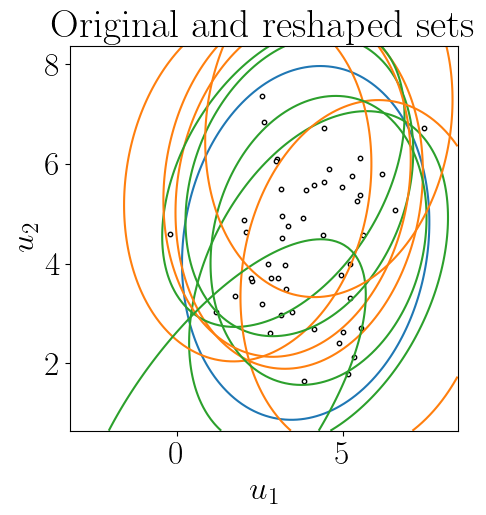

In [19]:
plt.figure(figsize=(5, 5))
plt.title("Original and reshaped sets")
# Set axis label for the contour plot
plt.xlabel(r"$u_1$")
plt.ylabel(r"$u_2$")

plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
for k in range(5):
  plt.contour(x_mesh,y_mesh
  ,unc_level_learned[k,:,:], [1], colors = ["tab:green"], label = "Final Set")
  plt.contour(x_mesh,y_mesh
  ,unc_level[k,:,:], [1], colors = ["tab:orange"], label = "Final Set")
# for scene in range(5):
#     plt.contour(x_mesh,y_mesh,g_level_learned[scene,:,:], [1], colors = ["tab:purple"], label = "Initial Set")
#     # plt.contour(x_mesh,y_mesh,g_level_base[scene,:,:], [1], colors = ["tab:green"], label = "Final Set")

plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
# plt.savefig("Reshaped_ctrs.pdf", bbox_inches='tight')
plt.show()

In [31]:
import os
import imageio

filenames = []
for i in range(1,len(A1_iters)):
    # 
    unc_level = level_set(A1_iters[i], b1_iters[i],contextual = True)
    plt.figure(figsize=(5, 5))
    plt.title("Original and reshaped sets")
    # Set axis label for the contour plot
    plt.xlabel(r"$u_1$")
    plt.ylabel(r"$u_2$")

    plt.contour(x_mesh,y_mesh,unc_level_base, [1], colors = ["tab:blue"], label = "Initial Set")
    for k in range(3):
        plt.contour(x_mesh,y_mesh,unc_level[k,:,:], [1], colors = ["tab:red"], label = "trained Set")
    # plt.contour(x_mesh,y_mesh,unc_level_learned, [1], colors = ["tab:green"], label = "Final Set")
    # for scene in range(num_scenarios):
    #     plt.contour(x_mesh,y_mesh,g_level[scene,:,:], [1], colors = ["tab:purple"], label = "Initial Set")

    filename = f'gif_images/{i}.png'
    filenames.append(filename)

    plt.scatter(train[:,0],train[:,1], color = "white",edgecolors= "black", s = 10)
    plt.savefig(filename)
    plt.close()

with imageio.get_writer('gifs/newsvendor.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)